In [1]:
import pandas as pd
import numpy as np

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv'
!wget $data

--2025-08-12 03:16:38--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298573 (292K) [text/plain]
Saving to: ‘laptops.csv.1’

laptops.csv.1       100%[===================>] 291.58K  --.-KB/s    in 0.02s   

2025-08-12 03:16:38 (16.6 MB/s) - ‘laptops.csv.1’ saved [298573/298573]



In [3]:
df = pd.read_csv('laptops.csv')

In [4]:
df.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [5]:
df.columns

Index(['Laptop', 'Status', 'Brand', 'Model', 'CPU', 'RAM', 'Storage',
       'Storage type', 'GPU', 'Screen', 'Touch', 'Final Price'],
      dtype='object')

In [6]:
df.dtypes

Laptop           object
Status           object
Brand            object
Model            object
CPU              object
RAM               int64
Storage           int64
Storage type     object
GPU              object
Screen          float64
Touch            object
Final Price     float64
dtype: object

In [7]:
df.isnull().sum()

Laptop             0
Status             0
Brand              0
Model              0
CPU                0
RAM                0
Storage            0
Storage type      42
GPU             1371
Screen             4
Touch              0
Final Price        0
dtype: int64

In [8]:
df.nunique()

Laptop          2160
Status             2
Brand             27
Model            121
CPU               28
RAM                9
Storage           12
Storage type       2
GPU               44
Screen            29
Touch              2
Final Price     1440
dtype: int64

In [9]:
df.index

RangeIndex(start=0, stop=2160, step=1)

<Axes: xlabel='Final Price', ylabel='Count'>

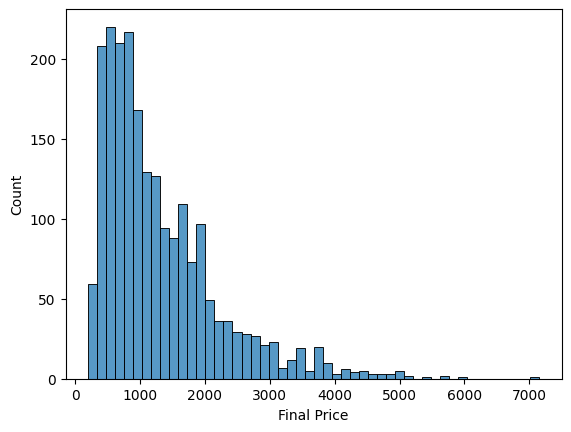

In [10]:
import seaborn as sns
sns.histplot(df['Final Price'], bins=50)

In [11]:
df.columns = df.columns.str.lower().str.replace(' ','_')
df.columns

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'ram', 'storage',
       'storage_type', 'gpu', 'screen', 'touch', 'final_price'],
      dtype='object')

In [12]:
df.dtypes

laptop           object
status           object
brand            object
model            object
cpu              object
ram               int64
storage           int64
storage_type     object
gpu              object
screen          float64
touch            object
final_price     float64
dtype: object

In [13]:
strings = list(df.dtypes[df.dtypes == 'object'].index)
strings

['laptop', 'status', 'brand', 'model', 'cpu', 'storage_type', 'gpu', 'touch']

In [14]:
for col in strings:
    df[col] = df[col].str.lower().str.replace(' ','_')

In [15]:
df.head()

,laptop,status,brand,model,cpu,ram,storage,storage_type,gpu,screen,touch,final_price
0,asus_expertbook_b1_b1502cba-ej0436x_intel_core...,new,asus,expertbook,intel_core_i5,8,512,ssd,NaN,15.6,no,1009.00
1,alurin_go_start_intel_celeron_n4020/8gb/256gb_...,new,alurin,go,intel_celeron,8,256,ssd,NaN,15.6,no,299.00
2,asus_expertbook_b1_b1502cba-ej0424x_intel_core...,new,asus,expertbook,intel_core_i3,8,256,ssd,NaN,15.6,no,789.00
3,msi_katana_gf66_12uc-082xes_intel_core_i7-1270...,new,msi,katana,intel_core_i7,16,1000,ssd,rtx_3050,15.6,no,1199.00
4,hp_15s-fq5085ns_intel_core_i5-1235u/16gb/512gb...,new,hp,15s,intel_core_i5,16,512,ssd,NaN,15.6,no,669.01


In [16]:
features = ['ram', 'storage', 'screen', 'final_price']
df[features].isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

In [17]:
df.ram.median()

np.float64(16.0)

In [18]:
df_flt = df[features]
n = len(df_flt)
idx = np.arange(n)

In [19]:
np.random.seed(42)
np.random.shuffle(idx)
idx

array([2079,  668, 2073, ..., 1130, 1294,  860], shape=(2160,))

In [20]:
df_flt.index = idx
df_flt = df_flt.reset_index(drop=True)

In [21]:
n_test = int(n * 0.2)
n_val = int(n * 0.2)
n_train = n - n_test - n_val

In [22]:
df_test = df_flt[:n_test]
df_val = df_flt[n_test : n_test + n_val]
df_train = df_flt[n_test+n_val:]

In [23]:
df_val = df_val.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

In [24]:
len(df_train) + len(df_val) + len(df_test)

2160

In [25]:
df_train.head()

,ram,storage,screen,final_price
0,32,1000,17.3,2649.44
1,16,512,14.0,846.31
2,8,512,15.6,414.84
3,8,256,15.6,399.37
4,16,512,15.6,1069.00


In [26]:
y_train = np.log1p(df_train.final_price.values)
del df_train['final_price']


<Axes: ylabel='Count'>

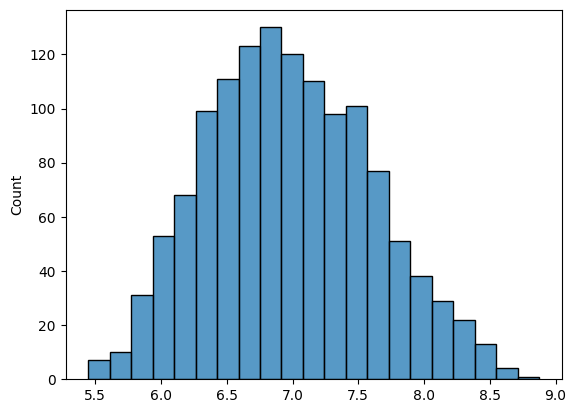

In [30]:
sns.histplot(y_train)

In [31]:
df_train_a = {}
df_train_b = {}

for col in df_train.columns:
    df_train_a[col] = df_train[col].fillna(0)
    df_train_b[col] = df_train[col].fillna(df_train[col].mean)

df_train_a = pd.DataFrame(df_train_a)
df_train_b = pd.DataFrame(df_train_b)


In [35]:
for col in df_train.columns:
    print(col)
    print(df_train[col].nunique())
    print(df_train[col].unique()[:5])

ram
8
[32 16  8  4 12]
storage
11
[1000  512  256  128   64]
screen
26
[17.3 14.  15.6 11.6 16.2]


In [47]:
list(df_train.ram.value_counts().head().index)

[16, 8, 32, 4, 64]

In [52]:
list(df_train.ram.unique()[:5])

[np.int64(32), np.int64(16), np.int64(8), np.int64(4), np.int64(12)]

In [45]:
categorical = {}

for c in df_train.columns:
    categorical[c] = list(df_train[c].value_counts().head().index)